In [1]:
%matplotlib inline

import os
import subprocess 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from __future__ import unicode_literals
from IPython.core.display import display, HTML

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-ticks')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 0.75
mpl.rcParams['xtick.major.width'] = 0.75
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['ytick.major.width'] = 0.75
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup():
    fig = plt.figure(figsize=(13,7))
    ax = fig.add_subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    return fig, ax

In [3]:
def extract_time(sid):
    
    # Matteo's Magic

    profile = pd.read_csv('./%s/%s.prof'%(sid,sid), 
                          header=None,
                          names=['tstamp','sid','uid','state','event','msg'],
                          usecols=['tstamp','sid','uid','state'])

    # Keep only unit profiles
    profile = profile.dropna(subset=['uid'])
    profile = profile[profile.uid.str.contains('unit')]

    # Elminate redundant 'Done' state 
    profile.loc[profile.state == 'Done'] = profile.loc[(profile.sid.str.contains('OutputFileTransfer')) & 
                                                   (profile.state == 'Done')]
    profile = profile.dropna()
    if profile[profile.state == 'Done'].state.size != 112:
        print 'ERROR'

    # Purge useless info from session ID
    profile['sid'] = profile['sid'].apply(lambda x: x.split(':')[1])
    profile = profile.reset_index(drop=True)
    
    # Keep only execution-related states
    txs = profile[(profile.state == 'Executing') | 
                  (profile.state == 'StagingOutput') | 
                  (profile.state == 'AgentStagingOutputPending')].copy()

    # Profiles are a mess in 0.42 :( 
    # - Duplicates of state StagingOutput 
    # - spare presence of state AgentStagingOutputPending
    for uid in txs.uid.tolist():
        txs[txs.uid == uid]
        if len(txs[(txs.uid == uid) & (txs.state == 'StagingOutput')]['state'].tolist()) >= 2:
            txs = txs.drop(txs.index[(txs.uid == uid) &
                                     (txs.state == 'StagingOutput') & 
                                     (txs.sid.str.contains('Thread'))])
        if 'AgentStagingOutputPending' in txs[txs.uid == uid].state.tolist() and \
           'StagingOutput' in txs[txs.uid == uid].state.tolist():
            txs = txs.drop(txs.index[(txs.uid == uid) & 
                                      (txs.state == 'AgentStagingOutputPending')])

    # We are done with sid
    txs = txs.drop('sid', axis=1)

    # Calculate $T_x$
    txs.tstamp = pd.to_numeric(txs.tstamp, errors='coerce')
    txs = txs.pivot(index='uid', columns='state', values='tstamp')
    txs['Tx'] = txs['StagingOutput']-txs['Executing']
    
    return txs

In [4]:
def extract_namd_time(sid):
    
    stdouts = glob('%s-pilot.0000/unit.*/STDOUT'%sid)
    df = pd.DataFrame(columns=['stage','NAMD Duration'])
    df.index.name = 'uid'
    
    exec_prof = open('./execution_profile_rp.session.two.jdakka.017398.0008.csv','r')
    read_exec_lines = exec_prof.readlines()

    for line in read_exec_lines[2:]:

        if int(line.split(',')[1].strip().split('_')[1].strip()) in [4,5,6]:

            uid = line.split(',')[0].strip()
            stage = line.split(',')[1].strip()
            out = '%s-pilot.0000/%s/STDOUT'%(sid, uid)
        
            f = open(out,'r')
            last_line = f.readlines()[-1:][0]
        
            namd_dur = float(last_line.split('~')[1].strip().split(',')[0].strip()[:-1])
        
            df.loc[uid] = [stage, float(namd_dur/8)]
        
    return df.sort_index()

In [5]:
def extract_pilot_runtime(sid):
    profile = '%s/pilot.0000/bootstrap_1.prof' % sid
    duration = subprocess.check_output("grep 'ACTIVE,QED' %s | cut -f1 -d," % profile, shell=True).rstrip()
    return duration

In [6]:
# Extract Tx-related timestamps from RP profiles
rp_prof = extract_time('rp.session.two.jdakka.017398.0008')

# Extract Tx from NAMD logs
namd_prof = extract_namd_time('rp.session.two.jdakka.017398.0008')

# Extract pilot run time Tr from RP agent's profile
pilot_runtime = extract_pilot_runtime('rp.session.two.jdakka.017398.0008')

# Merge NAMD execution time with RP timestamps
comb_prof = rp_prof.merge(namd_prof, right_index=True,left_index=True)
comb_prof.columns = ['StartExecuting', 'StagingOutput','TxRP', 'Stage', 'TxNAMD']

# Calculate the end timestamp of Tx on the base of NAMD logs
comb_prof['StopExecutingNAMD'] = comb_prof['StartExecuting']+comb_prof['TxNAMD']

# Add pilot's run time (Tr, TTR=Tr for runs with pnly 1 pilot) to DF
comb_prof['TTR'] = pilot_runtime

# Retain only useful measures
comb_prof = comb_prof[['Stage', 'StartExecuting','StopExecutingNAMD','TxRP','TxNAMD','TTR']]

# Display results.
display(comb_prof)

,Stage,StartExecuting,StopExecutingNAMD,TxRP,TxNAMD,TTR
uid,,,,,,
unit.000048,stage_4,3141.3991,3695.3991,3210.7232,554.000,39349.5020
unit.000049,stage_4,3172.5032,3726.3782,24409.4142,553.875,39349.5020
unit.000050,stage_4,3172.5036,3727.0036,1345.5275,554.500,39349.5020
unit.000051,stage_4,3172.5035,3726.8785,1247.3150,554.375,39349.5020
unit.000052,stage_4,3892.5753,4445.2003,1891.3487,552.625,39349.5020
unit.000053,stage_4,3904.1550,4459.0300,1347.9842,554.875,39349.5020
unit.000054,stage_4,3913.1296,4467.2546,10247.3314,554.125,39349.5020
unit.000055,stage_4,3913.1307,4467.2557,13729.8589,554.125,39349.5020
unit.000056,stage_5,4424.8645,11057.1145,31784.6544,6632.250,39349.5020


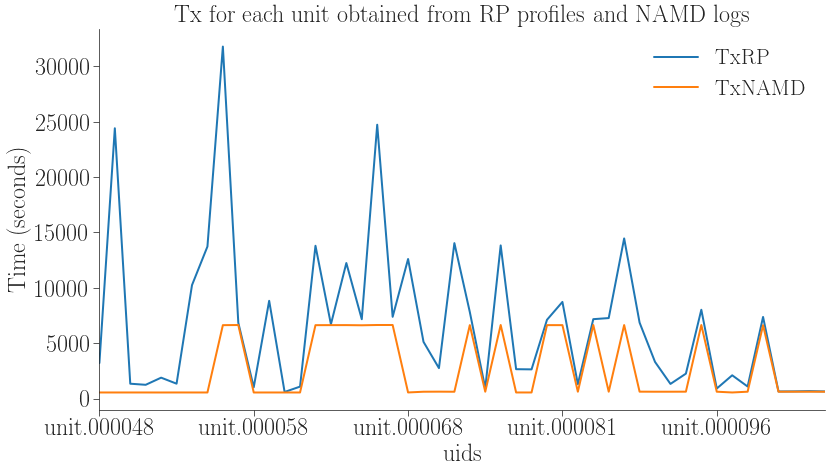

In [7]:
fig, ax = fig_setup()
comb_prof.plot(kind='line', y=['TxRP', 'TxNAMD'], ax=ax)

ax.set_xlabel('uids')
ax.set_ylabel('Time (seconds)')
ax.set_title('Tx for each unit obtained from RP profiles and NAMD logs')

# Analysis
The plot shows large discrepancies between $T_x$ as measured by RP and NAMD. These discrepancies appear to be determined by spurious but common failures to timestamp the end of the execution of the unit in RP 0.42. The following substantiate this statement:

In [8]:
sid = 'rp.session.two.jdakka.017398.0008'
profile = pd.read_csv('./%s/%s.prof'%(sid,sid), 
                          header=None,
                          names=['tstamp','sid','uid','state','event','msg'],
                          usecols=['tstamp','uid','state'])

# Keep only unit profiles
profile = profile.dropna(subset=['uid'])
profile = profile[profile.uid.str.contains('unit')]

profile[profile.uid == 'unit.000049']

,tstamp,uid,state
389,3166.7297,unit.000049,New
390,3167.3417,unit.000049,PendingInputStaging
391,3167.4058,unit.000049,StagingInput
394,3167.5064,unit.000049,AgentStagingInputPending
403,3172.5032,unit.000049,Executing
763,27581.9174,unit.000049,StagingOutput
764,27582.0201,unit.000049,Done
765,27583.0971,unit.000049,Done


Note how the time stampe for the states *StagingOutput* and *Done* are the same and that the state *AgentStagingInputPending* is missing. The hypothesis is that RP missed to timestamp the end of the unit execution and timestamped *StagingOutput* and *Done* when all the units had terminated execution of after that when tearing down the agent. This hypothesis can be investigated by looking at the duration of the pilot activity ($T_r$) and comparing it to the total time spent execution units ($TTX$) calculated by using NAMD $T_x$ durations.